# Reduce Dimensionality using Mean and Auto Encoding

Here we will use the combined data files containing wind time series information to reduce them to monthly values (using the mean) and then applying an autoencoder to obtain one wind variable (one column as output).

After this has been done, we add both the month (encoded as month_sin and month_cos to get circular dependencies) and the cost column manually in excel. That final file will then be filtered (if needed) and used as input to our surrogate models. So between the output of this code and the next steps is some manual engineering necessary.

# AutoEncoder for MC sampled data 

Index(['time', 'NL11', 'NL12', 'NL13', 'NL21', 'NL22', 'NL23', 'NL31', 'NL32',
       'NL33', 'NL34', 'NL41', 'NL42'],
      dtype='object')
                NL11      NL12      NL13      NL21      NL22      NL23  \
year_month                                                               
2019-01     0.447577  0.385912  0.304885  0.286855  0.290074  0.351335   
2019-02     0.408896  0.346024  0.265764  0.253981  0.254707  0.313131   
2019-03     0.376126  0.326189  0.254201  0.245410  0.245106  0.288074   
2019-04     0.286258  0.225876  0.190959  0.183894  0.180983  0.211005   
2019-05     0.261709  0.227725  0.176738  0.170259  0.160679  0.198988   
...              ...       ...       ...       ...       ...       ...   
2042-08     0.251776  0.196804  0.153020  0.143342  0.138106  0.181832   
2042-09     0.301283  0.243208  0.183748  0.177190  0.178014  0.222532   
2042-10     0.363991  0.312776  0.235756  0.230476  0.225433  0.278664   
2042-11     0.381992  0.327978  0.238548  0.2

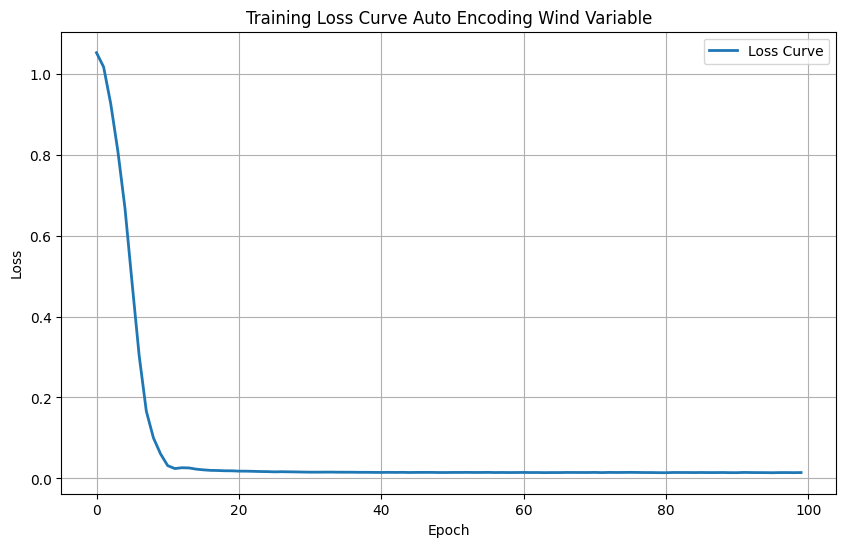

            Encoded_1
year_month           
2019-01      3.246696
2019-02      1.897643
2019-03      1.230649
2019-04     -0.887394
2019-05     -1.328234
...               ...
2042-08     -1.780104
2042-09     -0.802194
2042-10      0.870721
2042-11      1.115272
2042-12      2.238104

[288 rows x 1 columns]


In [10]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt  # Import for plotting

# Load the data
file_path = '/kaggle/input/data-wouter-combined/combined_data_wouter.csv'
data = pd.read_csv(file_path, sep=',')

print(data.columns)

# Convert 'time' column to datetime
data['time'] = pd.to_datetime(data['time'])

# Assign unique years to repeated patterns
hours_per_year = 365 * 24  # Assuming no leap years
unique_patterns = len(data) // hours_per_year  # Number of repeated yearly patterns

# Create a year offset for each row based on its position in the dataset
data['unique_year'] = (data.index // hours_per_year) + 2019  # Start from 2019
data['time'] = data.apply(lambda row: row['time'].replace(year=row['unique_year']), axis=1)

# Extract year and month for grouping
data['year_month'] = data['time'].dt.to_period('M')

# Group by year and month, taking the mean of all rows within each month
nl_columns = [col for col in data.columns if col.startswith("NL")]
monthly_data = data.groupby('year_month')[nl_columns].mean()

print(monthly_data)
# Standardize the NL columns
scaler = StandardScaler()
scaled_data = scaler.fit_transform(monthly_data)

# Convert to PyTorch tensors
scaled_data_tensor = torch.tensor(scaled_data, dtype=torch.float32)

# Create a DataLoader
batch_size = 64
dataset = TensorDataset(scaled_data_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define the autoencoder architecture
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, encoding_dim)  # Compressed representation
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)  # Reconstruct the original input
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

# Define parameters
input_dim = scaled_data.shape[1]  # Number of features
encoding_dim = 1  # Number of dimensions to reduce to

# Initialize the model, loss function, and optimizer
model = Autoencoder(input_dim, encoding_dim)
criterion = nn.MSELoss()  # Reconstruction loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the autoencoder
epochs = 100
losses = []  # To store loss values

for epoch in range(epochs):
    epoch_loss = 0.0
    for batch in dataloader:
        batch_data = batch[0]  # Extract the data from the DataLoader
        optimizer.zero_grad()
        encoded, decoded = model(batch_data)
        loss = criterion(decoded, batch_data)  # Compare reconstruction with input
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    avg_loss = epoch_loss / len(dataloader)
    losses.append(avg_loss)  # Store average loss for the epoch
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {avg_loss}")

# Plot the loss curve
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), losses, label='Loss Curve', linewidth = 2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve Auto Encoding Wind Variable')
plt.legend()
plt.grid()
plt.savefig('loss_curve.png', format='png', dpi=300)  # Save as PNG with 300 DPI
plt.show()

# Extract the encoded (reduced) representation
with torch.no_grad():
    encoded_data, _ = model(scaled_data_tensor)

# Convert the encoded data to a DataFrame for analysis
encoded_df = pd.DataFrame(
    encoded_data.numpy(),
    columns=[f"Encoded_{i+1}" for i in range(encoding_dim)],
    index=monthly_data.index.astype(str)  # Use year-month as index
)

# Save or view the reduced data
print(encoded_df)


In [3]:
# Reset the index to make year_month a column
encoded_df = encoded_df.reset_index()

# Rename the columns for clarity
encoded_df.columns = ['year_month', 'encoded_1']

# Split year_month into separate year and month columns
encoded_df[['year', 'month']] = encoded_df['year_month'].str.split('-', expand=True)

# Convert year and month to integers for further use
encoded_df['year'] = encoded_df['year'].astype(int)
encoded_df['month'] = encoded_df['month'].astype(int)

# Drop the original year_month column if no longer needed
encoded_df = encoded_df.drop(columns=['year_month'])

# Display the final DataFrame
print(encoded_df)


     encoded_1  year  month
0     2.370859  2019      1
1     1.423244  2019      2
2     0.976431  2019      3
3    -0.857277  2019      4
4    -1.272461  2019      5
..         ...   ...    ...
283  -1.736254  2042      8
284  -0.762823  2042      9
285   0.713061  2042     10
286   0.897595  2042     11
287   1.690542  2042     12

[288 rows x 3 columns]


In [6]:

montecarlo_df = encoded_df.iloc[:,0]
print(montecarlo_df)
montecarlo_df.to_excel('autoencoder_1_component_1_column_montecarlo_data.xlsx', index=False)

encoded_df.to_csv('encoded_1_component_montecarlo_data.csv')


0      2.370859
1      1.423244
2      0.976431
3     -0.857277
4     -1.272461
         ...   
283   -1.736254
284   -0.762823
285    0.713061
286    0.897595
287    1.690542
Name: encoded_1, Length: 288, dtype: float32


# AutoEncoder for Original Data

In [3]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

# Load and preprocess the data
file_path = '/kaggle/input/windnuts-data-original/wind_nuts.csv'
data = pd.read_csv(file_path, sep=';')


# Split concatenated column into separate columns
data = data.iloc[:, 0].str.split(',', expand=True)
data.columns = ['time', 'NL11', 'NL12', 'NL13', 'NL21', 'NL22', 'NL23',
                'NL31', 'NL32', 'NL33', 'NL34', 'NL41', 'NL42']

# Convert 'time' column to datetime
data['time'] = pd.to_datetime(data['time'])

# Convert NL columns to numeric, coercing errors to NaN
nl_columns = [col for col in data.columns if col.startswith("NL")]
data[nl_columns] = data[nl_columns].apply(pd.to_numeric, errors='coerce')

# Handle NaN values (e.g., drop rows with NaN)
data.dropna(subset=nl_columns, inplace=True)

# Extract year and month for grouping
data['year_month'] = data['time'].dt.to_period('M')

# Group by year and month, taking the mean of all rows within each month
monthly_data = data.groupby('year_month')[nl_columns].mean()

# Standardize the NL columns
scaler = StandardScaler()
scaled_data = scaler.fit_transform(monthly_data)

# Convert to PyTorch tensors
scaled_data_tensor = torch.tensor(scaled_data, dtype=torch.float32)

# Create a DataLoader
batch_size = 64
dataset = TensorDataset(scaled_data_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define the autoencoder architecture
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, encoding_dim)  # Compressed representation
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)  # Reconstruct the original input
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

# Define parameters
input_dim = scaled_data.shape[1]  # Number of features
encoding_dim = 1  # Number of dimensions to reduce to

# Initialize the model, loss function, and optimizer
model = Autoencoder(input_dim, encoding_dim)
criterion = nn.MSELoss()  # Reconstruction loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the autoencoder
epochs = 100
for epoch in range(epochs):
    epoch_loss = 0.0
    for batch in dataloader:
        batch_data = batch[0]  # Extract the data from the DataLoader
        optimizer.zero_grad()
        encoded, decoded = model(batch_data)
        loss = criterion(decoded, batch_data)  # Compare reconstruction with input
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {epoch_loss / len(dataloader)}")

# Extract the encoded (reduced) representation
with torch.no_grad():
    encoded_data, _ = model(scaled_data_tensor)

# Convert the encoded data to a DataFrame for analysis
encoded_df = pd.DataFrame(
    encoded_data.numpy(),
    columns=[f"Encoded_{i+1}" for i in range(encoding_dim)],
    index=monthly_data.index.astype(str)  # Use year-month as index
)

# Save or view the reduced data
print(encoded_df)


Epoch 0, Loss: 1.0206733122467995
Epoch 10, Loss: 0.02400984615087509
Epoch 20, Loss: 0.02000556082930416
Epoch 30, Loss: 0.019564750138670206
Epoch 40, Loss: 0.018935519852675498
Epoch 50, Loss: 0.0191626634914428
Epoch 60, Loss: 0.01903422875329852
Epoch 70, Loss: 0.018982776440680027
Epoch 80, Loss: 0.019059290760196745
Epoch 90, Loss: 0.01886462070979178
            Encoded_1
year_month           
1980-01      0.742703
1980-02      1.521750
1980-03     -0.343418
1980-04      0.015746
1980-05      0.918950
...               ...
2019-08      1.465027
2019-09      0.434964
2019-10     -0.682795
2019-11      0.597361
2019-12     -1.887350

[480 rows x 1 columns]


In [4]:
# Reset the index to make year_month a column
encoded_df = encoded_df.reset_index()

# Rename the columns for clarity
encoded_df.columns = ['year_month', 'encoded_1']

# Split year_month into separate year and month columns
encoded_df[['year', 'month']] = encoded_df['year_month'].str.split('-', expand=True)

# Convert year and month to integers for further use
encoded_df['year'] = encoded_df['year'].astype(int)
encoded_df['month'] = encoded_df['month'].astype(int)

# Drop the original year_month column if no longer needed
encoded_df = encoded_df.drop(columns=['year_month'])

# Display the final DataFrame
print(encoded_df)


     encoded_1  year  month
0     0.742703  1980      1
1     1.521750  1980      2
2    -0.343418  1980      3
3     0.015746  1980      4
4     0.918950  1980      5
..         ...   ...    ...
475   1.465027  2019      8
476   0.434964  2019      9
477  -0.682795  2019     10
478   0.597361  2019     11
479  -1.887350  2019     12

[480 rows x 3 columns]


In [5]:

montecarlo_df = encoded_df.iloc[:,0]
print(montecarlo_df)
montecarlo_df.to_excel('autoencoder_1_component_1_column_original_data.xlsx', index=False)

#encoded_df.to_csv('encoded_1_component_montecarlo_data.csv')


0      0.742703
1      1.521750
2     -0.343418
3      0.015746
4      0.918950
         ...   
475    1.465027
476    0.434964
477   -0.682795
478    0.597361
479   -1.887350
Name: encoded_1, Length: 480, dtype: float32
